In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.stats import chi2
import Regression
import seaborn as sns
import math

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import norm
# Set some options for printing all the columns
np.set_printoptions(precision = 20, threshold = sys.maxsize)
np.set_printoptions(linewidth = np.inf)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
# pd.options.display.float_format = '{:,.10}'.format

pd.options.display.float_format = '{:.7f}'.format

In [2]:
claim_history = pd.read_excel('claim_history.xlsx')
claim_history.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,REVOKED,MVR_PTS,CAR_AGE,URBANICITY,CLM_AMT,CLM_COUNT,EXPOSURE
0,63581743,0,1939-03-16,60.0000000,0,11.0000000,67000.0000000,No,NaN,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,No,3,18.0000000,Highly Urban/ Urban,0,0,0.1890000
1,132761049,0,1956-01-21,43.0000000,0,11.0000000,91000.0000000,No,257000.0000000,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,No,0,1.0000000,Highly Urban/ Urban,0,0,1.0000000
2,921317019,0,1951-11-18,48.0000000,0,11.0000000,53000.0000000,No,NaN,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,No,2,10.0000000,Highly Urban/ Urban,0,0,1.0000000
3,727598473,0,1964-03-05,35.0000000,1,10.0000000,16000.0000000,No,124000.0000000,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,No,3,10.0000000,Highly Urban/ Urban,0,0,0.8280000
4,450221861,0,1948-06-05,51.0000000,0,14.0000000,NaN,No,306000.0000000,Yes,M,Below High Sc,Blue Collar,32,Private,15440,7,Minivan,yes,No,0,6.0000000,Highly Urban/ Urban,0,0,0.7290000


In [3]:
claim_history.columns

Index(['ID', 'KIDSDRIV', 'BIRTH', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME',
       'PARENT1', 'HOME_VAL', 'MSTATUS', 'GENDER', 'EDUCATION', 'OCCUPATION',
       'TRAVTIME', 'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR',
       'REVOKED', 'MVR_PTS', 'CAR_AGE', 'URBANICITY', 'CLM_AMT', 'CLM_COUNT',
       'EXPOSURE'],
      dtype='object')

In [4]:
claim_history.shape

(10302, 26)

In [5]:
target = 'CLM_AMT'
cat_pred = ['CAR_TYPE', 'CAR_USE', 'EDUCATION', 'GENDER', 'MSTATUS', 'PARENT1', 'RED_CAR', 'REVOKED', 'URBANICITY']
int_pred = ['AGE', 'BLUEBOOK', 'CAR_AGE', 'HOME_VAL', 'HOMEKIDS', 'INCOME', 'YOJ', 'KIDSDRIV', 'MVR_PTS', 'TIF', 'TRAVTIME']
offset = 'EXPOSURE'

train_data = claim_history[[target] + cat_pred + int_pred + [offset]]

for x in ['BLUEBOOK', 'HOME_VAL', 'INCOME']:
    train_data[x] = train_data[x]/1000

train_data = train_data[train_data['EXPOSURE'] > 0].dropna().reset_index(drop=False) 
train_data.head()

train_data_copy = claim_history[[target] + cat_pred + int_pred + [offset]]
train_data_copy = train_data_copy.dropna().reset_index(drop=True) 

In [6]:
train_data.shape

(5715, 23)

In [7]:
print(train_data.isnull().sum())

index         0
CLM_AMT       0
CAR_TYPE      0
CAR_USE       0
EDUCATION     0
GENDER        0
MSTATUS       0
PARENT1       0
RED_CAR       0
REVOKED       0
URBANICITY    0
AGE           0
BLUEBOOK      0
CAR_AGE       0
HOME_VAL      0
HOMEKIDS      0
INCOME        0
YOJ           0
KIDSDRIV      0
MVR_PTS       0
TIF           0
TRAVTIME      0
EXPOSURE      0
dtype: int64


## QUESTION 1

### We will first drop all missing values casewisely in all the predictors, the target variable, and the offset variable. Then, we will only use complete observations for training our models.

<b>a) (10 points). We will first estimate the Tweedie distribution’s Power parameter 𝑝 and Scale parameter 𝜙. To this end, we will calculate the sample means and the sample variances of the claim amount for each value combination of the categorical predictors. Then, we will train a linear regression model to help us estimate the two parameters. What are their values? Please provide us with your appropriate chart.

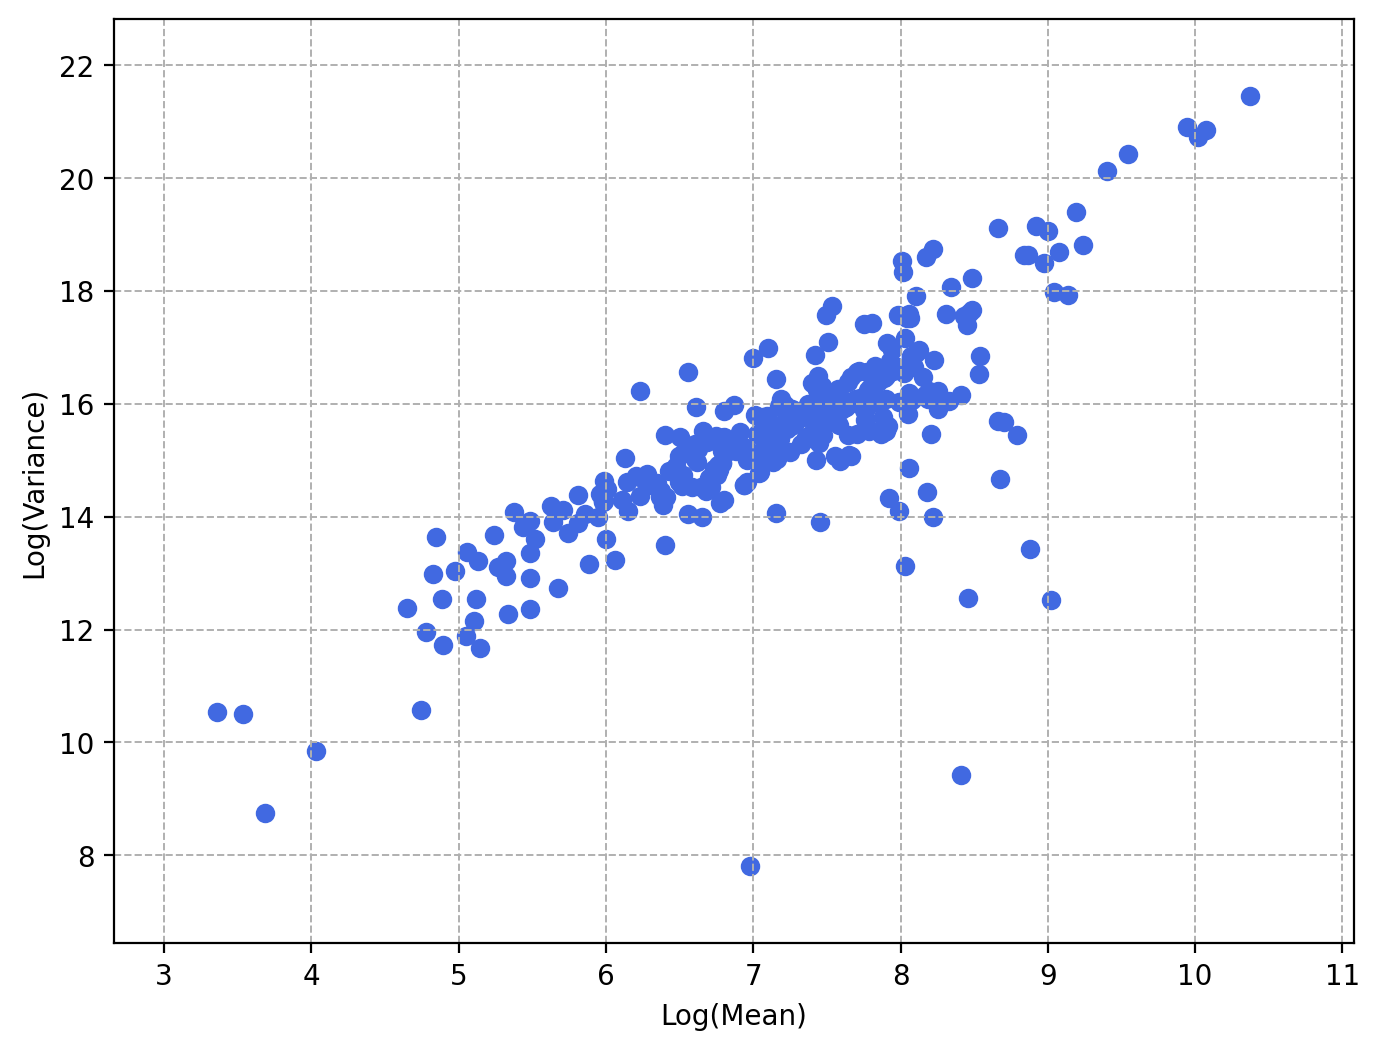

The Power parameter p = 1.2840608802234919
The Scale parameter 𝜙 = 495.39032035257253


In [8]:
yName = 'CLM_AMT'
ename = 'EXPOSURE'

y_train = train_data['CLM_AMT']
o_train = np.log(train_data['EXPOSURE'])

xtab = pd.pivot_table(train_data, values = yName, index = cat_pred,
                          columns = None, aggfunc = ['count', 'mean', 'var'])

cell_stats = xtab[['mean','var']].reset_index().droplevel(1, axis = 1)

ln_Mean = np.where(cell_stats['mean'] > 1e-16, np.log(cell_stats['mean']), np.NaN)
ln_Variance = np.where(cell_stats['var'] > 1e-16, np.log(cell_stats['var']), np.NaN)

use_cell = np.logical_not(np.logical_or(np.isnan(ln_Mean), np.isnan(ln_Variance)))

X_train = ln_Mean[use_cell]
y_train = ln_Variance[use_cell]

# Scatterplot of lnVariance vs lnMean
plt.figure(figsize = (8,6), dpi = 200)
plt.scatter(X_train, y_train, c = 'royalblue')
plt.xlabel('Log(Mean)')
plt.ylabel('Log(Variance)')
plt.margins(0.1)
plt.grid(axis = 'both', linewidth = 0.7, linestyle = 'dashed')
plt.show()

X_train = pd.DataFrame(X_train, columns = ['ln_Mean'])
X_train.insert(0, 'Intercept', 1.0)

y_train = pd.Series(y_train, name = 'ln_Variance')

result_list_intercept = Regression.LinearRegression (X_train, y_train)

tweediePower = result_list_intercept[0][1]
tweediePhi = np.exp(result_list_intercept[0][0])

print("The Power parameter p = " + str(tweediePower))
print("The Scale parameter 𝜙 = " + str(tweediePhi))

<b>b) We will use the Forward Selection method to enter predictors into our model. Our entry threshold is 0.05. Please provide a summary report of the Forward Selection in a table. The report should include (1) the Step Number, (2) the Predictor Entered, (3) the Model Degree of Freedom (i.e., the number of non-aliased parameters), (4) the Quasi-Loglikelihood value, (5) the Deviance Chi-squares statistic between the current and the previous models, (6) the corresponding Deviance Degree of Freedom, and (7) the corresponding Chi-square significance.

In [9]:
def takeDevSig(s):
    return s[7]

nPredictor = len(cat_pred) + len(int_pred)
stepSummary = []

# Intercept only model
X0_train = train_data[[]]
X0_train.insert(0, 'Intercept', 1.0)

y_train = train_data[yName]

intercept_result_list = Regression.TweedieRegression (X0_train, y_train, o_train, tweedieP = tweediePower)
qllk0 = intercept_result_list[3]
df0 = len(intercept_result_list[4])
phi0 = intercept_result_list[7]

stepSummary.append([0, 'Intercept', ' ', df0, qllk0, phi0, np.NaN, np.NaN, np.NaN])

cName = cat_pred.copy()
iName = int_pred.copy()
entryThreshold = 0.05

In [10]:
for step in range(nPredictor):
   enterName = ''
   stepDetail = []

   # Enter the next predictor
   for X_name in cName:
      X_train = pd.get_dummies(train_data[[X_name]].astype('category'))
      if (X0_train is not None):
         X_train = X0_train.join(X_train)
      result_list = Regression.TweedieRegression (X_train, y_train, o_train, tweedieP = tweediePower)
      qllk1 = result_list[3]
      df1 = len(result_list[4])
      phi1 = result_list[7]
      devChiSq = 2.0 * (qllk1 - qllk0) / phi0
      devDF = df1 - df0
      devPValue = chi2.sf(devChiSq, devDF)
      stepDetail.append([X_name, 'categorical', df1, qllk1, phi1, devChiSq, devDF, devPValue])

   for X_name in iName:
      X_train = train_data[[X_name]]
      if (X0_train is not None):
         X_train = X0_train.join(X_train)
      result_list = Regression.TweedieRegression (X_train, y_train, o_train, tweedieP = tweediePower)
      qllk1 = result_list[3]
      df1 = len(result_list[4])
      phi1 = result_list[7]
      devChiSq = 2.0 * (qllk1 - qllk0) / phi0
      devDF = df1 - df0
      devPValue = chi2.sf(devChiSq, devDF)
      stepDetail.append([X_name, 'interval', df1, qllk1, phi1, devChiSq, devDF, devPValue])

   # Find a predictor to add, if any
   stepDetail.sort(key = takeDevSig, reverse = False)
   minSig = takeDevSig(stepDetail[0])
   if (minSig <= entryThreshold):
      add_var = stepDetail[0][0]
      add_type = stepDetail[0][1]
      df0 = stepDetail[0][2]
      qllk0 = stepDetail[0][3]
      phi0 = stepDetail[0][4]
      stepSummary.append([step+1] + stepDetail[0])
      if (add_type == 'categorical'):
         X0_train = X0_train.join(pd.get_dummies(train_data[[add_var]].astype('category')))
         cName.remove(add_var)
      else:
         X0_train = X0_train.join(train_data[[add_var]])
         iName.remove(add_var)
   else:
        break

# End of forward selection

stepSummary_df = pd.DataFrame(stepSummary, columns = ['Step','Predictor','Type','N Non-Aliased Parameters',
                                                          'Quasi Log-Likelihood', 'Phi', 'Deviance ChiSquare',
                                                          'Deviance DF', 'Deviance Sig.'])
stepSummary_df[['Step','Predictor','N Non-Aliased Parameters',
                                                          'Quasi Log-Likelihood', 'Deviance ChiSquare',
                                                          'Deviance DF', 'Deviance Sig.']]

,Step,Predictor,N Non-Aliased Parameters,Quasi Log-Likelihood,Deviance ChiSquare,Deviance DF,Deviance Sig.
0,0,Intercept,1,-2217255.2459542,NaN,NaN,NaN
1,1,URBANICITY,2,-2118973.9898024,506.5534053,1.0000000,0.0000000
2,2,EDUCATION,6,-2057057.2451762,333.8694706,4.0000000,0.0000000
3,3,CAR_TYPE,11,-1999000.2771733,322.2537740,5.0000000,0.0000000
4,4,PARENT1,12,-1953492.1239025,259.7083244,1.0000000,0.0000000
5,5,MVR_PTS,13,-1918087.9738579,206.7168485,1.0000000,0.0000000
6,6,TRAVTIME,14,-1902663.0152115,91.7091556,1.0000000,0.0000000
7,7,CAR_USE,15,-1888044.9607430,87.6009339,1.0000000,0.0000000
8,8,REVOKED,16,-1873857.9187160,85.6612435,1.0000000,0.0000000
9,9,KIDSDRIV,17,-1860340.5734043,82.2211227,1.0000000,0.0000000


<b>c) (10 points). We will calculate the Root Mean Squared Error, the Relative Error, the Pearson correlation, and the Distance correlation between the observed and the predicted claim amounts of your final model. Please comment on their values.

In [11]:
# Retrain the final model
result_list = Regression.TweedieRegression (X0_train, y_train, o_train, tweedieP = tweediePower)
y_pred = result_list[6]

# Simple Residual
y_simple_residual = y_train - y_pred

# Root Mean Squared Error
mse = np.mean(np.power(y_simple_residual, 2))
rmse = np.sqrt(mse)

print("The Root Mean Squared Error = " + str(rmse))

# Relative Error
relerr = mse / np.var(y_train, ddof = 0)
print("The Relative Error = " + str(relerr))

# R-Squared
pearson_corr = Regression.PearsonCorrelation (y_train, y_pred)
distance_corr = Regression.DistanceCorrelation (y_train, y_pred)

print("The Pearson Correlation = " + str(pearson_corr))
print("The Distance Correlation = " + str(distance_corr))

The Root Mean Squared Error = 4116.064009419276
The Relative Error = 1.0078985075249889
The Pearson Correlation = 0.18768098705727357
The Distance Correlation = 0.27019055675583475


The RMSE value represents the average difference between the predicted and actual amounts which being so high isn't great.<br>
The relative error suggests that the model's predictions are, on average, about 1% higher than the actual payout amounts.<br>
The Pearson correlation is positive and low which means there isn't much correlation between the variables.<br>
The Distance correlation is also positive and low which means there isn't much correlation between the variables.<br>

<b>d) (10 points). Please show a table of the complete set of parameters of your final model (including the aliased parameters). Besides the parameter estimates, please also include the standard errors, the 95% asymptotic confidence intervals, and the exponentiated parameter estimates. Conventionally, aliased parameters have zero standard errors and confidence intervals. Please also provide us with the final estimate of the Tweedie distribution’s scale parameter 𝜙.

In [12]:
result_list[0]

,Estimate,Standard Error,Lower 95% CI,Upper 95% CI,Exponentiated
Intercept,8.0045945,0.0070866,7.9907050,8.0184839,2994.6854164
URBANICITY_Highly Rural/ Rural,-1.6681625,0.0027758,-1.6736030,-1.6627221,0.1885933
URBANICITY_Highly Urban/ Urban,0.0000000,-0.0000000,0.0000000,0.0000000,1.0000000
EDUCATION_Bachelors,-0.1407007,0.0035220,-0.1476037,-0.1337977,0.8687493
EDUCATION_Below High Sc,0.2015884,0.0043330,0.1930958,0.2100810,1.2233443
EDUCATION_High School,0.0966325,0.0039945,0.0888033,0.1044616,1.1014555
EDUCATION_Masters,-0.1387404,0.0034407,-0.1454841,-0.1319967,0.8704540
EDUCATION_PhD,0.0000000,-0.0000000,0.0000000,0.0000000,1.0000000
CAR_TYPE_Minivan,-0.7502918,0.0030645,-0.7562980,-0.7442855,0.4722287
CAR_TYPE_Panel Truck,0.0175044,0.0032363,0.0111614,0.0238474,1.0176585


In [13]:
print("The final estimate of the Tweedie distribution’s scale parameter 𝜙 = " + str(result_list[7]))

The final estimate of the Tweedie distribution’s scale parameter 𝜙 = 319.3817800403747


<b>d) (10 points). Please generate a Two-way Lift chart for comparing your final model with the Intercept-only model. Based on the chart, what will you conclude about your final model?

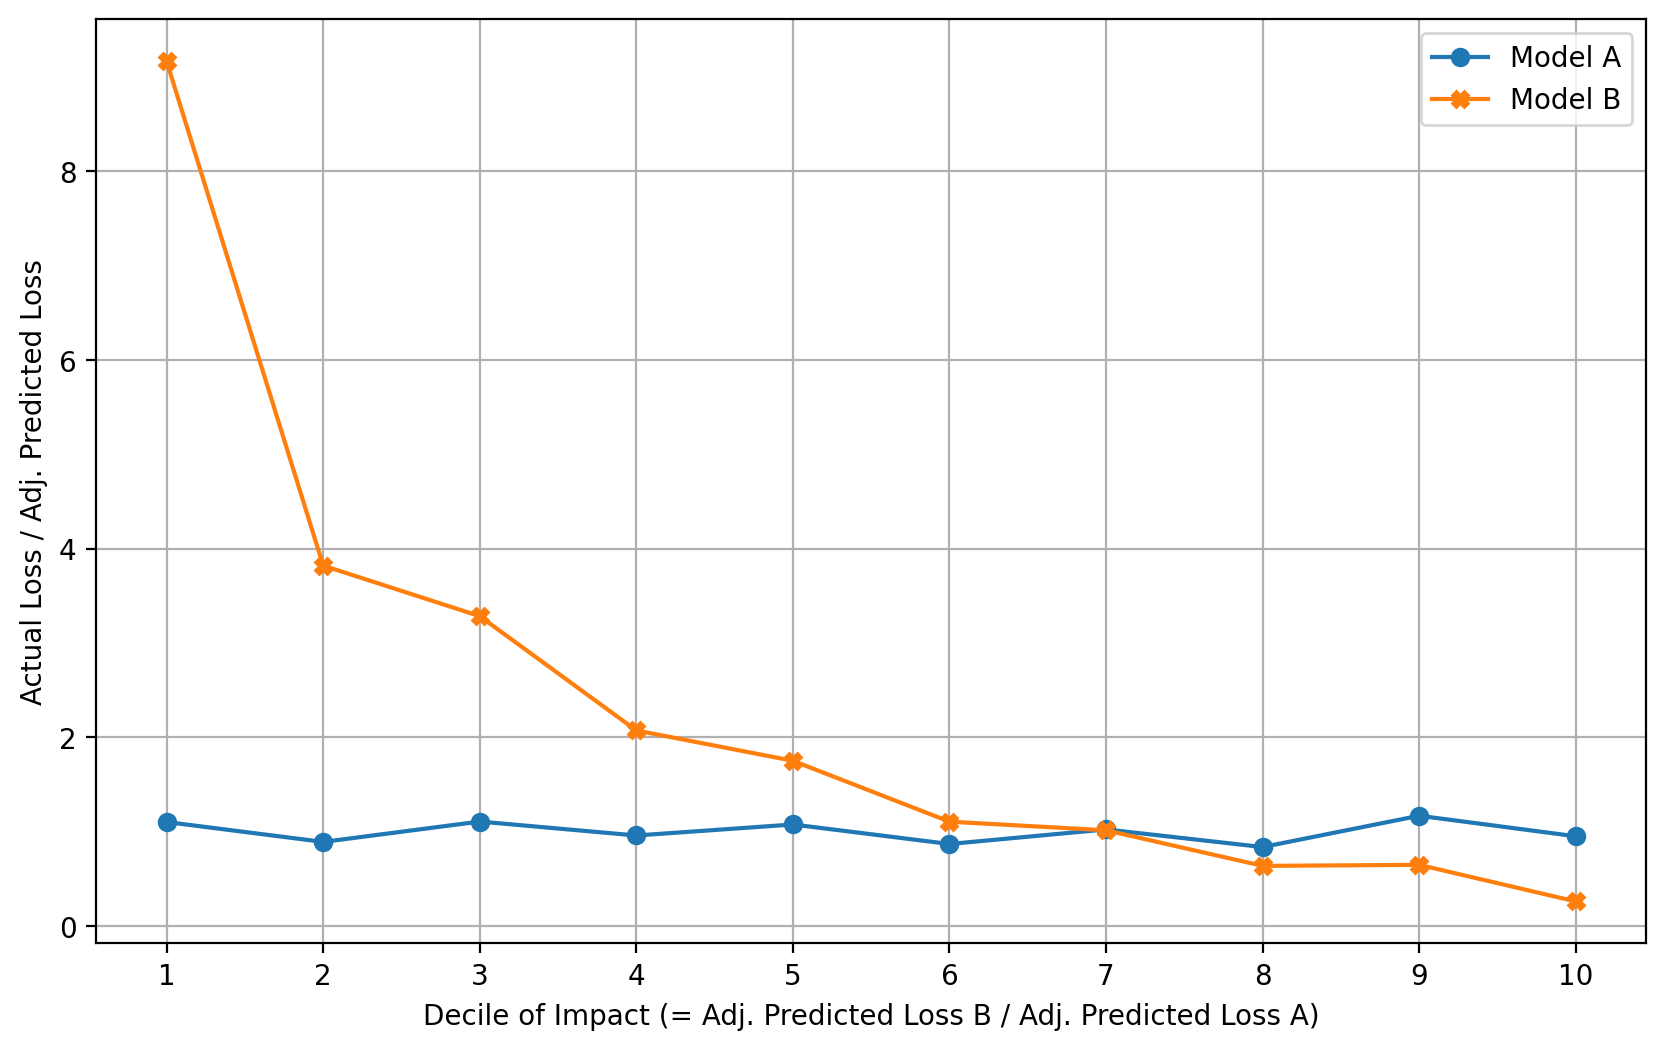

In [14]:
#intercept_result_list
#result_list
y_pred_A = intercept_result_list[6].reindex(train_data['index'])
y_pred_A.name = 'Model A'

y_pred_B = result_list[6].reindex(train_data['index'])
y_pred_B.name = 'Model B'

# Normalize the model prediction

prediction = claim_history[[yName, ename]].join(y_pred_A).join(y_pred_B).dropna()
column_sums = np.sum(prediction[['EXPOSURE', 'CLM_AMT','Model A','Model B']], axis = 0)

adjP_CLM_AMT_A = prediction['Model A'] * (column_sums['CLM_AMT'] / column_sums['Model A'])
adjP_CLM_AMT_B = prediction['Model B'] * (column_sums['CLM_AMT'] / column_sums['Model B'])

prediction = prediction.join(pd.DataFrame({'AdjModel A': adjP_CLM_AMT_A, 'AdjModel B': adjP_CLM_AMT_B}))
prediction['impact'] = adjP_CLM_AMT_B / adjP_CLM_AMT_A

prediction.sort_values(by = 'impact', axis = 0, ascending = True, inplace = True)
prediction['Cumulative Exposure'] = prediction['EXPOSURE'].cumsum()

cumulative_exposure_cutoff = np.arange(0.1, 1.1, 0.1) * column_sums['EXPOSURE']
decile = np.zeros_like(prediction['Cumulative Exposure'], dtype = int)
for i in range(10):
   decile = decile + np.where(prediction['Cumulative Exposure'] > cumulative_exposure_cutoff[i], 1, 0)
   
prediction['decile'] = decile + 1

xtab = pd.pivot_table(prediction, index = 'decile', columns = None,
                          values = ['EXPOSURE','CLM_AMT','AdjModel A', 'AdjModel B'],
                          aggfunc = ['sum'])

loss_ratio_A = xtab['sum','CLM_AMT'] / xtab['sum','AdjModel A']
loss_ratio_B = xtab['sum','CLM_AMT'] / xtab['sum','AdjModel B']

MAE_A = np.mean(np.abs((loss_ratio_A - 1.0)))
MAE_B = np.mean(np.abs((loss_ratio_B - 1.0)))
 
plt.figure(figsize = (10,6), dpi = 200)
plt.plot(xtab.index, loss_ratio_A, marker = 'o', label = 'Model A')
plt.plot(xtab.index, loss_ratio_B, marker = 'X', label = 'Model B')
plt.xlabel('Decile of Impact (= Adj. Predicted Loss B / Adj. Predicted Loss A)')
plt.ylabel('Actual Loss / Adj. Predicted Loss')
plt.xticks(range(1,11))
plt.grid()
plt.legend()
plt.show()

At Decile #1, Model B is preferred as its Loss Ratio is much lower and Model A is preferred as its Loss Ratio is closer to the ideal loss ratio of 1.

## QUESTION 2

<h3>Krall, Uthoff, and Harley (1975) analyzed data from a study on multiple myeloma in which researchers treated sixty-five patients with alkylating agents. Of those patients, forty-eight died during the study, and seventeen survived.<br><br>
The data set is in the myeloma.csv. The variable Time represents the survival time in months from diagnosis. The variable VStatus consists of two values, 0 and 1, indicating whether the patient was alive or dead, respectively, at the end of the study. If the value of VStatus is 1, the patient died during the study. If the value of VStatus is 0, the patient was still alive at the end of the study and the corresponding value of Time is censored.<br><br>
Reference: John M. Krall, Vincent A. Uthoff, and John B. Harley (1975). “A Step-Up Procedure for Selecting Variables Associated with Survival.” Biometrics, volume 31, number 1, pages 49 – 57.

In [15]:
myeloma = pd.read_csv('myeloma.csv')
myeloma.head()

,Time,VStatus,LogBUN,HGB,Platelet,Age,LogWBC,Frac,LogPBM,Protein,SCalc
0,1.2500000,1,2.2175000,9.4000000,1,67,3.6628000,1,1.9542000,12,10
1,1.2500000,1,1.9395000,12.0000000,1,38,3.9868000,1,1.9542000,20,18
2,2.0000000,1,1.5185000,9.8000000,1,81,3.8751000,1,2.0000000,2,15
3,2.0000000,1,1.7482000,11.3000000,0,75,3.8062000,1,1.2553000,0,12
4,2.0000000,1,1.3010000,5.1000000,0,57,3.7243000,1,2.0000000,3,9


<b>a) (10 points). How many risk sets are there?

In [16]:
trainData = myeloma
nUnit = trainData.shape[0]
trainData['Status'] = np.where(trainData['VStatus'] == 0, 'Censored', 'Death')

# Calculate the Kaplan-Meier Product Limit Estimator for the Survival Function
xtab = pd.crosstab(index = trainData['Time'], columns = trainData['Status'])

lifeTable = pd.DataFrame({'Survival Time': 0, 'Number Left': nUnit, 'Number of Events': 0, 'Number Censored': 0}, index = [0])
lifeTable = lifeTable.append(pd.DataFrame({'Survival Time': xtab.index, 'Number of Events': xtab['Death'].to_numpy(),
                                               'Number Censored': xtab['Censored'].to_numpy()}),
                             ignore_index = True)

lifeTable['Number at Risk'] = nUnit

nTime = lifeTable.shape[0]
probSurvival = 1.0
hazardFunction = 0.0
seProbSurvival = 0.0
lifeTable.at[0,'Prob Survival'] = probSurvival
lifeTable.at[0,'Prob Failure'] = 1.0 - probSurvival
lifeTable.at[0,'Cumulative Hazard'] = hazardFunction

for i in np.arange(1,nTime):
   nDeath = lifeTable.at[i,'Number of Events']
   nAtRisk = lifeTable.at[i-1,'Number Left'] - lifeTable.at[i-1,'Number Censored']
   nLeft = nAtRisk - nDeath
   probSurvival = probSurvival * (nLeft / nAtRisk)
   seProbSurvival = seProbSurvival + nDeath / nAtRisk / nLeft
   hazardFunction = hazardFunction + (nDeath / nAtRisk)
   lifeTable.at[i, 'SE Prob Survival'] = seProbSurvival
   lifeTable.at[i,'Number Left'] = nLeft
   lifeTable.at[i,'Number at Risk'] = nAtRisk
   lifeTable.at[i,'Prob Survival'] = probSurvival
   lifeTable.at[i,'Prob Failure'] = 1.0 - probSurvival
   lifeTable.at[i,'Cumulative Hazard'] = hazardFunction

lifeTable['SE Prob Survival'] = lifeTable['Prob Survival'] * np.sqrt(lifeTable['SE Prob Survival'])

CIHalfWidth = norm.ppf(0.975) * lifeTable['SE Prob Survival']
u = lifeTable['Prob Survival'] - CIHalfWidth
lifeTable['Lower CI Prob Survival'] = np.where(u < 0.0, 0.0, u)

u = lifeTable['Prob Survival'] + CIHalfWidth
lifeTable['Upper CI Prob Survival'] = np.where(u > 1.0, 1.0, u)


print("The number of risk sets = " + str(len(lifeTable)-1))

The number of risk sets = 38


<b>(10 points). We will use the Kaplan-Meier Product Limit Estimator to create the life table. Please provide us with the life table.

In [17]:
lifeTable

,Survival Time,Number Left,Number of Events,Number Censored,Number at Risk,Prob Survival,Prob Failure,Cumulative Hazard,SE Prob Survival,Lower CI Prob Survival,Upper CI Prob Survival
0,0.0000000,65.0000000,0,0,65,1.0000000,0.0000000,0.0000000,NaN,NaN,NaN
1,1.2500000,63.0000000,2,0,65,0.9692308,0.0307692,0.0307692,0.0214198,0.9272487,1.0000000
2,2.0000000,60.0000000,3,0,63,0.9230769,0.0769231,0.0783883,0.0330515,0.8582973,0.9878566
3,3.0000000,59.0000000,1,0,60,0.9076923,0.0923077,0.0950549,0.0359031,0.8373236,0.9780610
4,4.0000000,59.0000000,0,2,59,0.9076923,0.0923077,0.0950549,0.0359031,0.8373236,0.9780610
5,5.0000000,55.0000000,2,0,57,0.8758435,0.1241565,0.1301427,0.0411040,0.7952811,0.9564058
6,6.0000000,51.0000000,4,0,55,0.8121457,0.1878543,0.2028699,0.0489214,0.7162616,0.9080299
7,7.0000000,48.0000000,3,2,51,0.7643725,0.2356275,0.2616935,0.0532544,0.6599958,0.8687492
8,8.0000000,46.0000000,0,1,46,0.7643725,0.2356275,0.2616935,0.0532544,0.6599958,0.8687492
9,9.0000000,44.0000000,1,0,45,0.7473864,0.2526136,0.2839157,0.0547129,0.6401511,0.8546217


<b>c) (10 points). According to the life table, what is the Probability of Survival and the Cumulative Hazard at a survival time of 18 months? What do these two values mean to a layperson?

In [18]:
prob_survival = lifeTable[lifeTable['Survival Time'] == 18]['Prob Survival'].values[0] = lifeTable[lifeTable['Survival Time'] == 18]['Prob Survival'].values[0]
cumulative_hazard = lifeTable[lifeTable['Survival Time'] == 18]['Cumulative Hazard'].values[0]

print("At a survival time of 18 months:")
print("The Probability of Survival = " + str(prob_survival))
print("The Cumulative Hazard = " + str(cumulative_hazard))

At a survival time of 18 months:
The Probability of Survival = 0.5094955102428145
The Cumulative Hazard = 0.6535471794159207


Patients with multiple myeloma and being treated with the alkylating agents have a probability of survival of 0.5094955102428145, but the avarage number of deaths at the time of 18 months is 0.6535471794159207.

<b>d) (10 points). Please generate the Survival Function graph using the Kaplan-Meier Product Limit Estimator life table. Since we measure the Time variable in the number of months, we will specify the x-axis ticks from 0 with an increment of 12. Besides plotting the Survival Function versus Time, you must also add the 95% Confidence Band. You might use the matplotlib fill_between() function to generate the Confidence Band as a band around the Survival Function. To receive the full credits, you must label the chart elements properly.

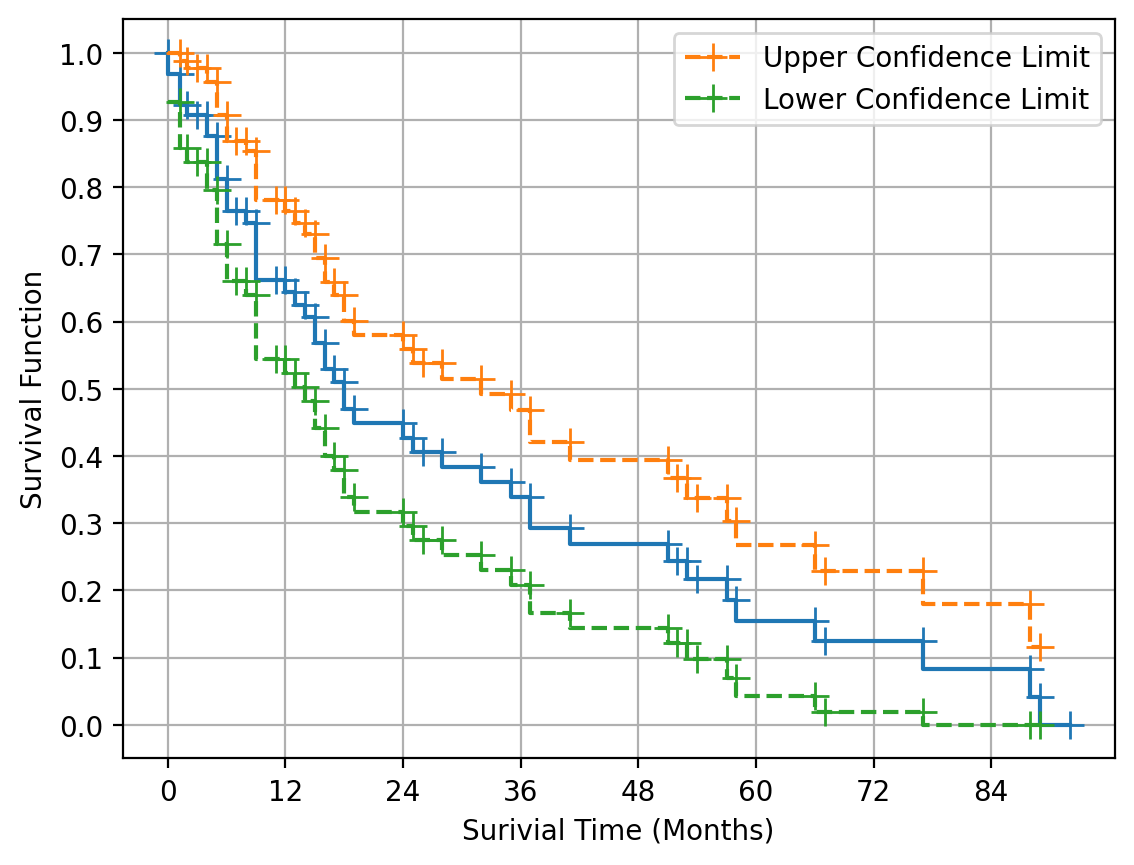

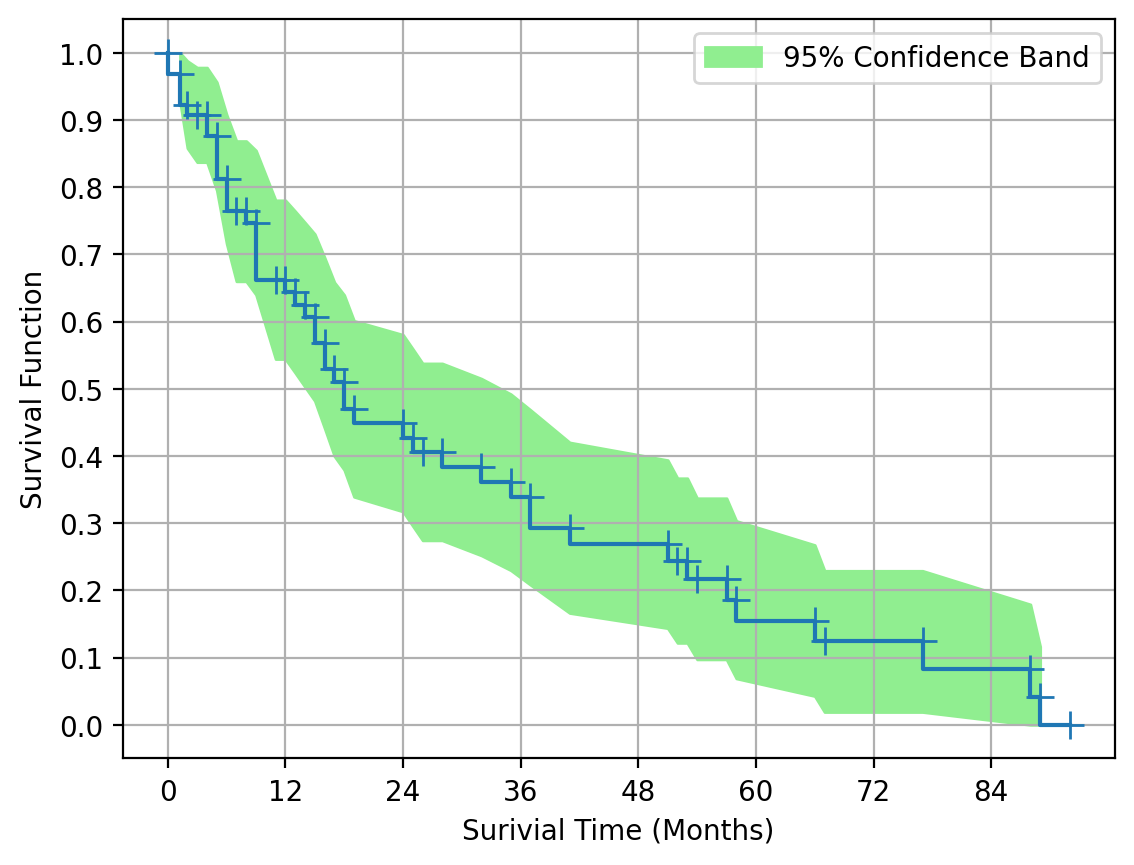

In [19]:
plt.figure(dpi = 200)
plt.plot(lifeTable['Survival Time'], lifeTable['Prob Survival'], marker = '+', markersize = 10, drawstyle = 'steps')
plt.plot(lifeTable['Survival Time'], lifeTable['Upper CI Prob Survival'], marker = '+',
         markersize = 10, drawstyle = 'steps', linestyle = 'dashed', label = 'Upper Confidence Limit')
plt.plot(lifeTable['Survival Time'], lifeTable['Lower CI Prob Survival'], marker = '+',
         markersize = 10, drawstyle = 'steps', linestyle = 'dashed', label = 'Lower Confidence Limit')
plt.xlabel('Surivial Time (Months)')
plt.ylabel('Survival Function')
plt.xticks(np.arange(0,96,12))
plt.yticks(np.arange(0.0,1.1,0.1))
plt.grid(axis = 'both')
plt.legend()
plt.show()


plt.figure(dpi = 200)
plt.plot(lifeTable['Survival Time'], lifeTable['Prob Survival'], marker = '+', markersize = 10, drawstyle = 'steps')
plt.fill_between(lifeTable['Survival Time'], lifeTable['Lower CI Prob Survival'], lifeTable['Upper CI Prob Survival'],
                 color = 'lightgreen', label = '95% Confidence Band')
plt.xlabel('Surivial Time (Months)')
plt.ylabel('Survival Function')
plt.xticks(np.arange(0,96,12))
plt.yticks(np.arange(0.0,1.1,0.1))
plt.grid(axis = 'both')
plt.legend()
plt.show()

<b>e) (10 points). Use Linear Interpolation to determine the Median Survival Time (in number of months) from the Kaplan-Meier Product Limit Estimator life table. Please round your answer up to the tenths place.

In [20]:
# For 18 & 19 months
xs = lifeTable[lifeTable['Survival Time'] == 18]['Prob Survival'].values[0]
xr = lifeTable[lifeTable['Survival Time'] == 19]['Prob Survival'].values[0]

a = (xs - 0.5)/(xs - xr)
b = 18-19
c = a * b
t = 18 - c
print("The Median Survival Time = " + str(round(t, 1)) + " months")

The Median Survival Time = 18.2 months
